In [514]:
from datascience import *
import numpy as np
import pandas as pd
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Earring Market Survey Data
Collected earring markey surveys on Google Surveys. Import as Numpy Table.


In [515]:
data = Table.read_table('survey_responses.csv')
data.show(1)

Timestamp,Gender,Age Range,Wear Regularly,Looking For,Design Preference,Jewelry Type,Comfortable Spending Fashion,Comfortable Spending Fine,Comfortable Spending Shipping?,Purchase Habits,Shop Online,Prefer Website,Care,Username
11/8/2020 15:44:19,Female,24 - 29,"Earrings, Necklaces","Style / Design, Comfort","Minimal, Simple",Fine / Semi-fine / Demi-fine jewelry -- Costlier and hig ...,Below RM 10,RM 20 - 40,Below RM5,Planned,3,4,2,I do not use a insta!!!!


# Data Cleaning
Shortened answers for a neater table and checked for null values


In [516]:
data = Table.read_table('survey_responses.csv')
#Handmade: Hand
#Fashion Jewelry: Fash
#Fine Jewlery: Fine
#None of the above: None (string)
def shorten1(x):
    return x[:4] 

def shorten2(y):
    if y == 'Implusively / Unplanned':
        y = 'Unplanned'
    return y

lst=[]
def null_detect(z):    #If nothing from this function prints, there is no null value detected
    for x in z:
        if x=='nan':      #Using np.nan produces error
            print("ERROR: Null Value Detected")
            lst.append(z[0])  #Append timestamps of rows with null values
            
data=data.drop('Username')    #Unnecessary column  
data.apply(null_detect) 
data=data.where('Timestamp', are.not_contained_in(lst))  #Drop rows will null values
data=data.relabel('Comfortable Spending Shipping?', 'Comfortable Spending Shipping').drop('Username')    #Removed '?' and dropped unnecessary Username column 

shortened_jewelry_type = data.apply(shorten1, 'Jewelry Type' )
shortened_purchase_habits = data.apply(shorten2, 'Purchase Habits')

survey = data.with_columns('Jewelry Type', shortened_jewelry_type, 'Purchase Habits', shortened_purchase_habits)
survey.show(1)

ERROR: Null Value Detected


Timestamp,Gender,Age Range,Wear Regularly,Looking For,Design Preference,Jewelry Type,Comfortable Spending Fashion,Comfortable Spending Fine,Comfortable Spending Shipping,Purchase Habits,Shop Online,Prefer Website,Care
11/8/2020 15:44:19,Female,24 - 29,"Earrings, Necklaces","Style / Design, Comfort","Minimal, Simple",Fine,Below RM 10,RM 20 - 40,Below RM5,Planned,3,4,2


# Exploratory Data Analysis

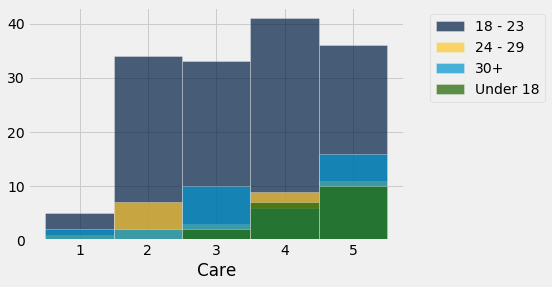

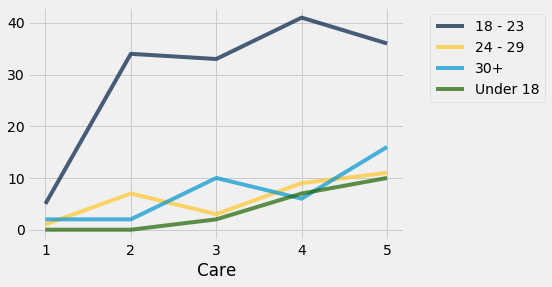

In [517]:
#Age Range VS. Care
pivot=survey.pivot('Age Range','Care')

pivot.bar('Care')
pivot.plot('Care')
warnings.filterwarnings('ignore')

#### Analysis:                                                                 
Particpants under age 18 tend to take better care of their jewelries                                  
Among participants who are above the age of 30, a majority of them take proper care of their jewelries                       
Overall, most people rate themselves 4 (on a scale of 1-5) when asked how well they take care of their jewelries


Purchase Habits,Comfortable Spending Shipping,count,percentage
Unplanned,Below RM5,80,34
Unplanned,RM 5 - 7,76,32
Planned,Below RM5,39,17
Planned,RM 5 - 7,29,12
Unplanned,Above RM 7,7,3
Planned,Above RM 7,4,2


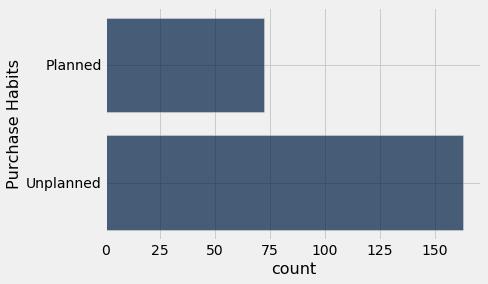

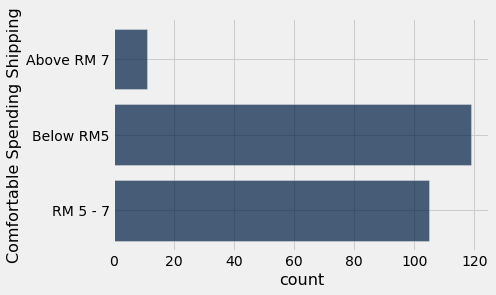

In [518]:
survey.group('Purchase Habits').barh('Purchase Habits')
survey.group('Comfortable Spending Shipping').barh('Comfortable Spending Shipping')
grouped=survey.group(['Purchase Habits', 'Comfortable Spending Shipping']).sort('count',descending=True)
grouped.with_column('percentage', np.round(grouped.column('count') / np.sum(grouped.column('count')) * 100,0))

#### Analysis
Most participants report that they purchase jewelries impulsively (unplanned)                                   
A majority of participants are willing to spend up to RM5 on shipping and purchase jewelries impulsively (unplanned)

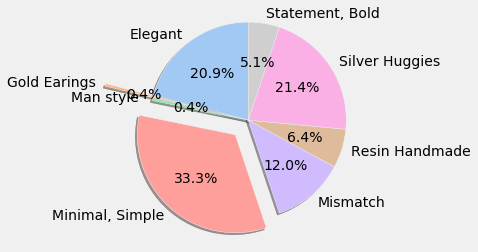

In [519]:
pref=survey.group('Design Preference').take(np.arange(8))
labels = pref.column(0)
sizes = pref.column(1)
explode = (0,0.5,0,0.2,0,0,0,0)  # only "explode" specified slices

fig1, ax1 = plots.subplots()
ax1.pie(sizes, labels=labels, explode=explode,autopct='%1.1f%%',
        shadow=True, startangle=90, colors=sns.color_palette("pastel"))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plots.show()

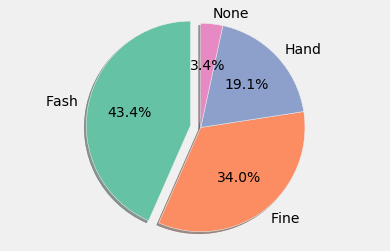

In [520]:
jtype=survey.group('Jewelry Type')
labels = jtype.column(0)
sizes = jtype.column(1)
explode = (0.1,0,0,0) 

fig2, ax2 = plots.subplots()
ax2.pie(sizes, labels=labels, explode=explode,autopct='%1.1f%%',
        shadow=True, startangle=90, colors=sns.color_palette("Set2"))
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plots.show()

#### Analysis: 
The popular jewelry choices among participants are Minimal designs and Fashion Earrings

# Label Encoding
Converted objects to numerical inputs. Easier for feature selection techniques, future algorithms etc.          
Researched on OneHot Label Encoding, decided not to use it to avoid having too many columns

In [521]:
# Creating instance of labelencoder
le = LabelEncoder()
for i in survey.select(1,2,5,6,7,8,9,10):      #only selecting columns that need to be encoded
    survey = survey.with_column(i + '_LE', le.fit_transform(survey.column(i)))
    #put encoded values in different columns of the same table for easier label-value reference in the future

survey.show(1)
#Columns 0 - 10 are originally objects (strings)
#Columns 11-13 are originally in numerical inputs
#Columns 14-21 are encoded  

Timestamp,Gender,Age Range,Wear Regularly,Looking For,Design Preference,Jewelry Type,Comfortable Spending Fashion,Comfortable Spending Fine,Comfortable Spending Shipping,Purchase Habits,Shop Online,Prefer Website,Care,Gender_LE,Age Range_LE,Design Preference_LE,Jewelry Type_LE,Comfortable Spending Fashion_LE,Comfortable Spending Fine_LE,Comfortable Spending Shipping_LE,Purchase Habits_LE
11/8/2020 15:44:19,Female,24 - 29,"Earrings, Necklaces","Style / Design, Comfort","Minimal, Simple",Fine,Below RM 10,RM 20 - 40,Below RM5,Planned,3,4,2,0,1,3,1,1,3,1,0


# Convert to Pandas Dataframe
Used array iteration and np.transpose

In [522]:
a=np.array(survey.row(np.arange(235)))
b=np.transpose(a)

df = pd.DataFrame(b, columns=survey.labels)
df.head(1)

,Timestamp,Gender,Age Range,Wear Regularly,Looking For,Design Preference,Jewelry Type,Comfortable Spending Fashion,Comfortable Spending Fine,Comfortable Spending Shipping,...,Prefer Website,Care,Gender_LE,Age Range_LE,Design Preference_LE,Jewelry Type_LE,Comfortable Spending Fashion_LE,Comfortable Spending Fine_LE,Comfortable Spending Shipping_LE,Purchase Habits_LE
0,11/8/2020 15:44:19,Female,24 - 29,"Earrings, Necklaces","Style / Design, Comfort","Minimal, Simple",Fine,Below RM 10,RM 20 - 40,Below RM5,...,4,2,0,1,3,1,1,3,1,0


# Feature Selection Techniques

I want to build two classification models for different target variables:
- Comfortable Spending Shipping (How much will a person be comfortable spending on domestic shipping)
- Purchase Habits (Whether a person will buy jewelries planned or unplanned) 

I explored three feature selection algorithms to identify the best features for predicting my target variables:
1. Feature Importance
2. Univariate Selection
3.Correlation Matrix with Heatmap

1: Feature Importance

Higher score, higher relevance towards output variable.                   
Feature importance is an inbuilt class that comes with Tree Based Classifiers                    
Used Extra Tree Classifier for extracting the top 10 features for the dataset.  

[0.11304872 0.12498424 0.12145104 0.02631248 0.10073868 0.12358177
 0.10391297 0.14410198 0.14186812]


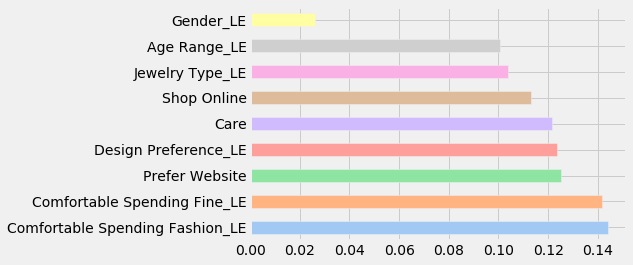

In [523]:
X = df.iloc[:,11:20]  #independent columns excluding Comfortable Spending Shipping
Y = df.iloc[:,20]    #target variable 1: Comfortable Spending Shipping
model = ExtraTreesClassifier()
model.fit(X,Y)                          
print(model.feature_importances_)       #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color=sns.color_palette("pastel"))    #Used seaborn pastel color palette

plots.show()

2: Univariate Selection 

This statistical test utilizes the SelectKBest class from the scikit-learn library.           
It uses chi-squared statistical test for non-negative features              
Extracted top 5 best features





In [524]:
X = df.iloc[:,11:21]  #independent columns excluding Purchase Habits
Y = df.iloc[:,21]    #target variable 2: Purchase Habits

#apply SelectKBest class to extract top 5 best features
bestfeatures = SelectKBest(score_func=chi2, k=5)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print scores top 5 best features

             Specs     Score
4     Age Range_LE  6.636045
6  Jewelry Type_LE  3.827462
3        Gender_LE  2.849369
0      Shop Online  0.661100
1   Prefer Website  0.594130


3: Correlation Matrix with Heatmap
    
States how the features are related to each other or the target variable.             
Correlation can be +ve or -ve              
Easy to identify which features are most related to the target variable                      
Plotted heatmap of correlated features using the seaborn library.

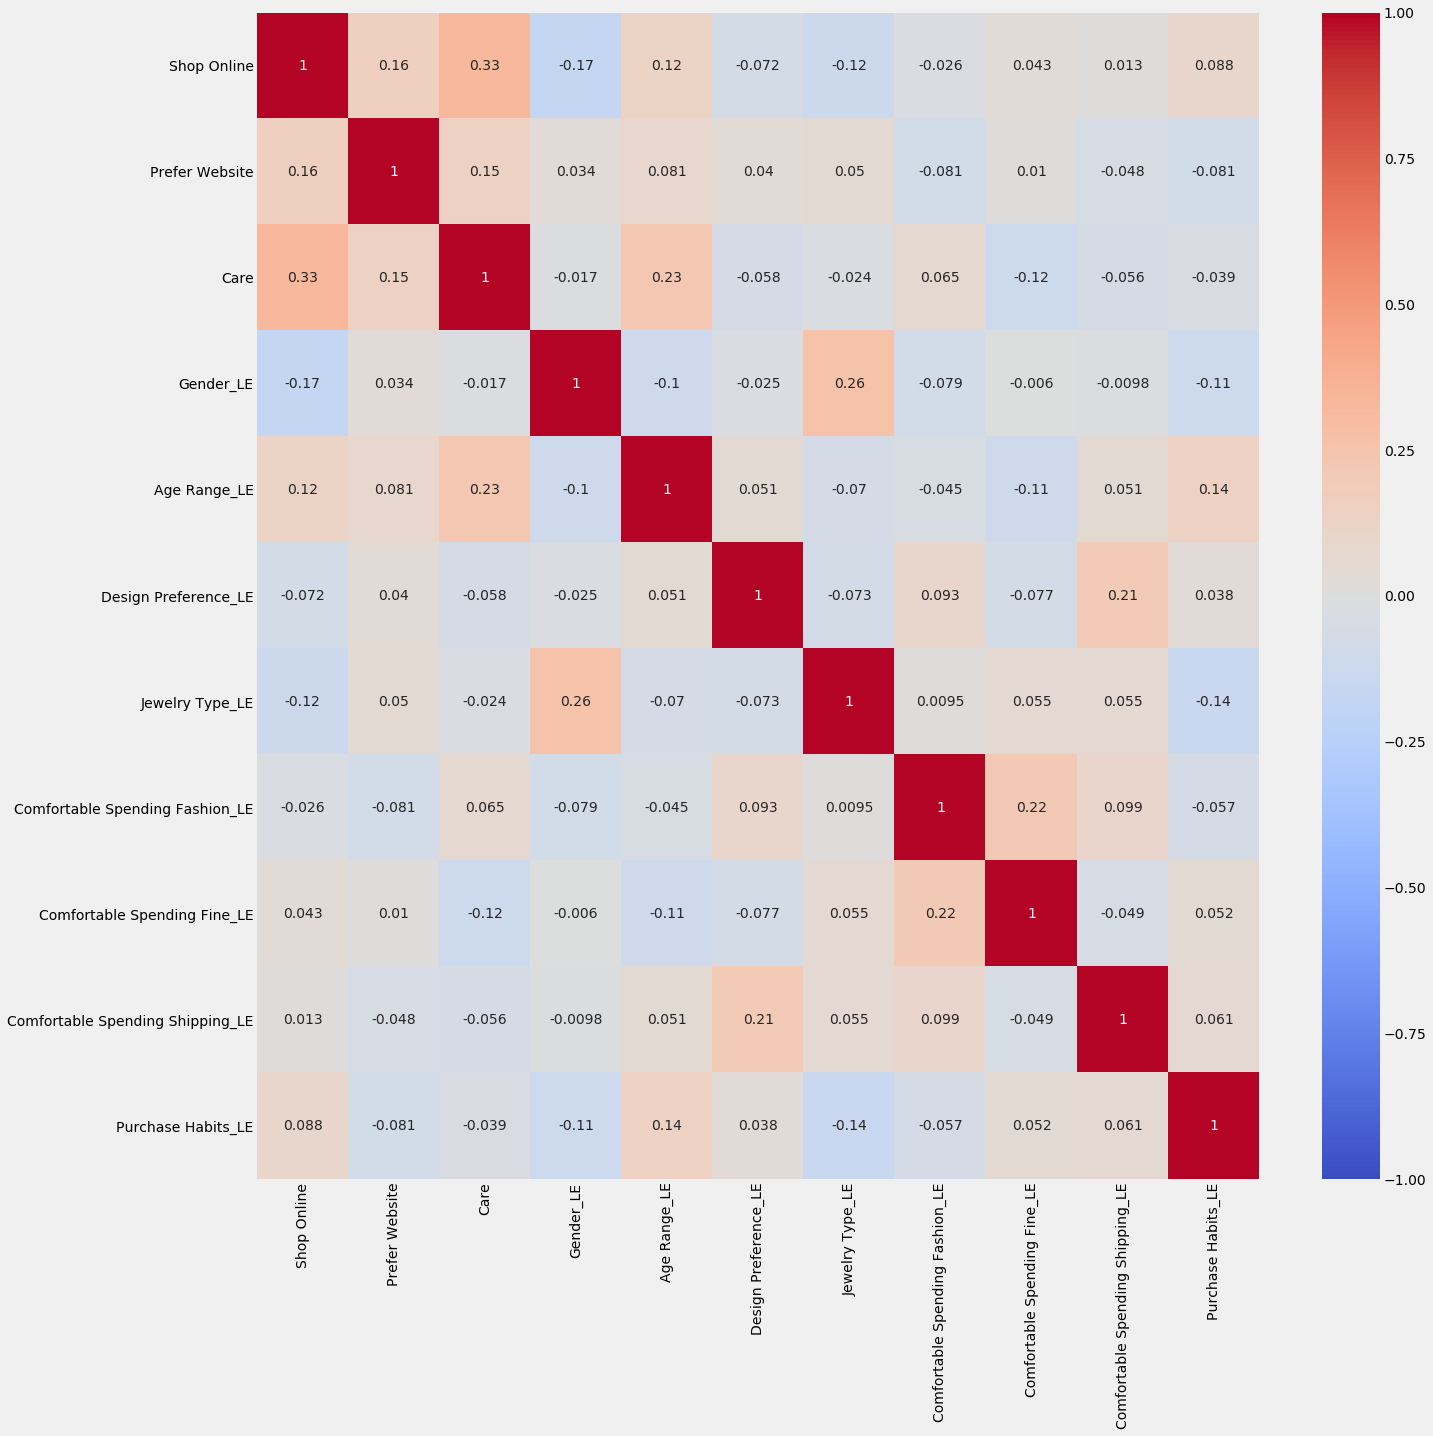

In [525]:
#get correlations of each features in dataset
subset = pd.DataFrame(df.iloc[:,11:22])
corrmat = subset.astype('float64').corr(method='pearson')
corrmat

#plotting and customizing heatmap  
plots.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, fmt ='.2g', vmin=-1, vmax=1, center= 0, cmap="coolwarm")


Feature Selection Conclusion (Top 5, according to sequence):    

**1. Feature Importance: (Comfortable Spending Shipping)**  
  
    Comfortable Spending Fashion_LE
    Comfortable Spending Fine_LE
    Prefer Website
    Care 
    Design Preference_LE 
    
**2. Univariate Selection: (Purchase Habits)** 

    Age Range_LE
    Jewelry Type_LE                                                      
    Gender_LE                                                           
    Prefer Website                                                           
    Shop Online
    
**3. Correlation Matrix with Heatmap**
    
   **Comfortable Spending Shipping:**
   
    Design Preference_LE
    Comfortable Spending Fashion_LE
    Purchase Habits_LE
    Jewelry Type_LE
    Age Range_LE

   **Purchase Habits:**
   
    Age Range_LE
    Shop Online
    Comfortable Spending Shipping_LE
    Comfortable Spending Fine_LE 
    Design Preference_LE

  
     

According to machinelearningmastery, A Chi-Squared test is the most appropriate feature selection technique for categorical input and categorical output.

# Logistic Regression
**Comfortable Spending Shipping**

Logistic Regression is suitable to predict categorical dependent variable using a set of independent variables. For predicting Comfortable Spending Shipping, linear regression is not appropriate since the output is not a continuous value. 

In [526]:
df.head(1)

,Timestamp,Gender,Age Range,Wear Regularly,Looking For,Design Preference,Jewelry Type,Comfortable Spending Fashion,Comfortable Spending Fine,Comfortable Spending Shipping,...,Prefer Website,Care,Gender_LE,Age Range_LE,Design Preference_LE,Jewelry Type_LE,Comfortable Spending Fashion_LE,Comfortable Spending Fine_LE,Comfortable Spending Shipping_LE,Purchase Habits_LE
0,11/8/2020 15:44:19,Female,24 - 29,"Earrings, Necklaces","Style / Design, Comfort","Minimal, Simple",Fine,Below RM 10,RM 20 - 40,Below RM5,...,4,2,0,1,3,1,1,3,1,0


In [527]:
#Set independent (X) and dependent (y) variables 
#After multiple trials, Correlation Matrix with Heatmap's top three features produced the most accurate classifier

X = df[['Design Preference_LE','Comfortable Spending Fashion_LE','Purchase Habits_LE']]
y = df['Comfortable Spending Shipping_LE']
print(X.describe())
print()
print(y.value_counts())

       Design Preference_LE Comfortable Spending Fashion_LE Purchase Habits_LE
count                   235                             235                235
unique                    9                               6                  2
top                       3                               3                  1
freq                     78                             103                163

1    119
2    105
0     11
Name: Comfortable Spending Shipping_LE, dtype: int64


In [528]:
#model testing -- 25% of the dataset
#model training -- 75% of the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [529]:
#Apply Logistic Regression
logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)
y_pred

array(['2', '1', '1', '1', '1', '1', '1', '1', '1', '2', '1', '1', '1',
       '1', '1', '1', '2', '2', '2', '2', '1', '2', '1', '2', '2', '1',
       '1', '1', '2', '2', '2', '2', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '2', '1', '1', '1', '1', '1', '2', '1',
       '1', '2', '1', '1', '1', '1', '2'], dtype=object)

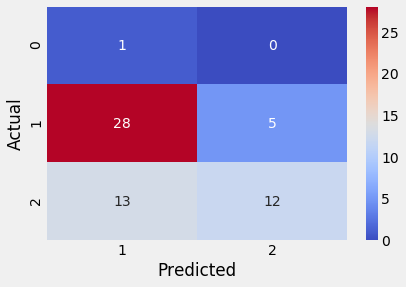

In [530]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm')

In [531]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.6779661016949152


# Prediction for New Set of Data

In [532]:
new_X={'Design Preference_LE': [8,0,5,7,2],
        'Comfortable Spending Fashion_LE': [0,3,2,1,0],
        'Purchase Habits_LE': [0,1,1,1,1],
      }

df2= pd.DataFrame(new_X, columns=['Design Preference_LE','Comfortable Spending Fashion_LE','Purchase Habits_LE'])
y_pred2=logistic_regression.predict(df2)

print(df2)
print(y_pred2)



   Design Preference_LE  Comfortable Spending Fashion_LE  Purchase Habits_LE
0                     8                                0                   0
1                     0                                3                   1
2                     5                                2                   1
3                     7                                1                   1
4                     2                                0                   1
['2' '1' '2' '2' '1']


# Random Forest Regression
**Purchase Habits**

In [533]:
#Set independent (X) and dependent (y) variables 
X = df[['Age Range_LE','Jewelry Type_LE','Gender_LE','Prefer Website','Shop Online' ]]
y = df['Purchase Habits_LE']
print(X.describe())
print()
print(y.value_counts())

#Training random forest regression model
X_trainf,X_testf,y_trainf,y_testf = train_test_split(X,y,test_size=0.25,random_state=83)
rfr = RandomForestRegressor()
rfr.fit(X_trainf, y_trainf)
y_predf = rfr.predict(X_testf)
y_predf


       Age Range_LE Jewelry Type_LE Gender_LE Prefer Website Shop Online
count           235             235       235            235         235
unique            4               4         3              5           5
top               0               0         0              3           3
freq            149             102       215            100          75

1    163
0     72
Name: Purchase Habits_LE, dtype: int64


array([0.45633333, 0.69133333, 0.09733333, 0.9575    , 0.135     ,
       0.75771429, 0.9       , 0.9825    , 0.965     , 0.89916667,
       0.08      , 0.27470418, 0.43      , 0.405     , 1.        ,
       0.50457143, 0.75596825, 0.9825    , 0.50501277, 0.50566667,
       0.09833333, 0.92      , 0.44      , 0.03      , 0.89916667,
       0.88857143, 0.945     , 0.935     , 0.59      , 0.03      ,
       1.        , 1.        , 0.91      , 0.9675    , 0.835     ,
       0.84633333, 0.67664286, 0.97      , 0.97      , 0.74      ,
       0.73316667, 0.03      , 0.54983333, 0.45083333, 0.50501277,
       0.64      , 0.50501277, 0.22506746, 0.40016667, 1.        ,
       0.47333333, 1.        , 0.50566667, 0.99      , 0.77      ,
       1.        , 0.67147619, 0.50457143, 0.41957143])

# Cross Validation 

To ensure that the model does not overfit the training data

In [534]:
scores = cross_val_score(rfr, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

Accuracy: -0.24 (+/- 0.29)


array([-0.03646406, -0.10969262, -0.4345243 , -0.34837007, -0.25839878])

# RFR Model Evaluation

In [535]:
#Evaluate how well model is performing on test data through root mean squared error
mse = np.sqrt(mean_squared_error(y_testf, y_predf))
mse 

0.525163240673054

In [536]:
#Prediction results
print("Random Forest Results:    ", y_predf[0:4].round(decimals=0))
print("Actual:                   ", list(y_testf[0:4]))


Random Forest Results:     [0. 1. 0. 1.]
Actual:                    ['0', '1', '0', '1']


# Linear Regression Inference
**Website Preference**

In [537]:
#use numpy table 
survey.show(2)

Timestamp,Gender,Age Range,Wear Regularly,Looking For,Design Preference,Jewelry Type,Comfortable Spending Fashion,Comfortable Spending Fine,Comfortable Spending Shipping,Purchase Habits,Shop Online,Prefer Website,Care,Gender_LE,Age Range_LE,Design Preference_LE,Jewelry Type_LE,Comfortable Spending Fashion_LE,Comfortable Spending Fine_LE,Comfortable Spending Shipping_LE,Purchase Habits_LE
11/8/2020 15:44:19,Female,24 - 29,"Earrings, Necklaces","Style / Design, Comfort","Minimal, Simple",Fine,Below RM 10,RM 20 - 40,Below RM5,Planned,3,4,2,0,1,3,1,1,3,1,0
11/8/2020 17:59:29,Female,18 - 23,"Earrings, Rings (not including wedding ring), Watches","Style / Design, Quality",Elegant,Fash,RM 10 - 20,RM 60 - 80,Below RM5,Unplanned,3,2,3,0,0,0,0,3,5,1,1


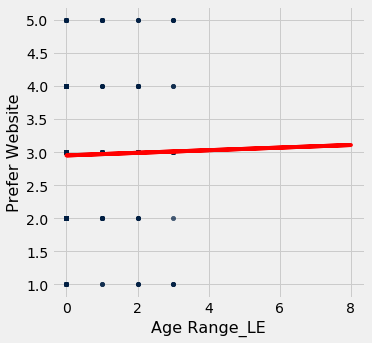

In [538]:
#Visualization
survey.scatter('Age Range_LE', 'Prefer Website')
m, b = np.polyfit(survey.column(16), survey.column(12), 1)
plots.plot(survey.column(16), m*survey.column(16)+b, color='r');

In [539]:
#Correlation
def standard_units(arr):
    return (arr- np.mean(arr)) / np.std(arr)

def correlation(tbl, col1, col2):
    r = np.mean(standard_units(tbl.column(col1)) * standard_units(tbl.column(col2)))
    return r

age_web_correlation = correlation(survey,'Age Range_LE','Prefer Website')
age_web_correlation

0.08097447901310399

# Hypothesis Testing & Bootstrapping

**Null:** There is no correlation between Age Range and Website Preference. Any Correlation is due to chance.
        
**Alternative:** There is some correlation between Age Range and Website Preference. Correlation is not equal to zero.

95% CI: [-0.050087403589519006, 0.21890298710742112], Reject null: True
There is no correlation between Age Range and Website Preference


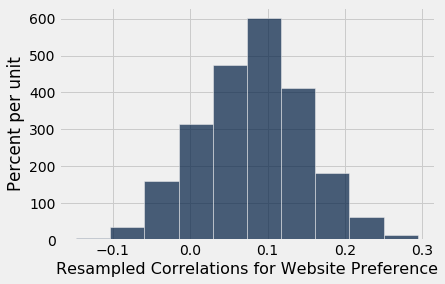

In [540]:
def one_resampled(table,colx,coly):
    new_tbl= table.sample()
    return correlation(new_tbl,colx, coly)

#Iterate 2000 times
stat_arr= [one_resampled(survey,'Age Range_LE','Prefer Website') for i in np.arange(2000)]

#Calculate 95% Confidence Interval
lower_bound = percentile(2.5, stat_arr)
upper_bound = percentile(97.5, stat_arr)
reject_null = 0 >= lower_bound and 0 <= upper_bound

#Histogram
Table().with_column("Resampled Correlations for Website Preference", stat_arr).hist()

#Results
print(f"95% CI: [{lower_bound}, {upper_bound}], Reject null: {reject_null}")
if reject_null:
    print('There is no correlation between Age Range and Website Preference')

# Analyzing Residuals

In [541]:
def parameters(tbl, colx, coly):
    x = tbl.column(colx)
    y = tbl.column(coly)
    
    r = correlation(tbl, colx, coly)
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_sd = np.std(x)
    y_sd = np.std(y)
    
    slope = (y_sd / x_sd) * r
    intercept = y_mean - (slope * x_mean)
    return make_array(slope, intercept)

web_slope = parameters(survey,'Age Range_LE','Prefer Website').item(0)
web_intercept = parameters(survey,'Age Range_LE','Prefer Website').item(1)


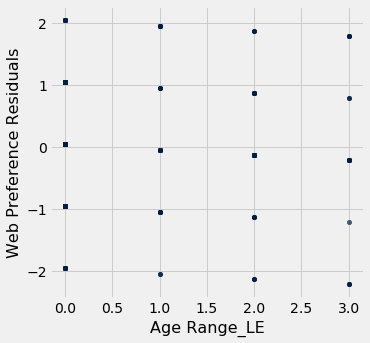

In [542]:
predicted_web = web_slope*survey.column('Age Range_LE') + web_intercept

web_residuals = survey.column('Prefer Website') - predicted_web

survey_with_residuals = survey.with_columns("Web Preference Residuals", web_residuals)

#Generate residual scatter plot
survey_with_residuals.scatter("Age Range_LE", "Web Preference Residuals")

If there is a trend in the residual plot,
linear regression is not a good model for 'Age Range_LE' vs 'Prefer  Website'

# References

**Data8 Table Functions & Methods**
http://data8.org/fa20/python-reference.html

**DataGood Pandas Cheat Sheet** https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

**Towards Data Science**

Feature Selelction Techniques:
https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e         
Data Cleaning Guide: 
https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4                   
Detecting Missing Values: https://towardsdatascience.com/data-cleaning-with-python-and-pandas-detecting-missing-values-3e9c6ebcf78b         
Categorical Encoding (LE & OHE) https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd

**Real Python**

Data Cleaning: https://realpython.com/python-data-cleaning-numpy-pandas/                          

**scikit-learn.org**

Label Encoding Syntax: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

**pluralsight.com**

Array iteration: https://www.pluralsight.com/guides/numpy-arrays-iterating

**matplotlib.org**

Color Maps: https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html

**seaborn.org**

Color Palettes: https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette

**Heartbeat**

Customizing Heatmaps: https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07

**Machine Learning Mastery**

How to Choose A Feature Selection Method: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

Random Forest Regression:                       
https://heartbeat.fritz.ai/random-forest-regression-in-python-using-scikit-learn-9e9b147e2153

**Data to Fish**

Logistic Regression in Python
https://datatofish.com/logistic-regression-python/


